[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/hnsw-faiss/hnsw_faiss.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/hnsw-faiss/hnsw_faiss.ipynb)

# HNSW in Faiss

In this notebook we will explore the implementation of HNSW in Facebook AI Similarity Search (Faiss).

First we import Faiss and our data (we will use the [Sift1M dataset](https://gist.github.com/jamescalam/928a374b85daffa49a565f3dc18d059c#file-get_sift1m-ipynb) as usual).

In [39]:
import faiss
import numpy as np

# now define a function to read the fvecs file format of Sift1M dataset
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')

# 1M samples
xb = read_fvecs('../../sift/sift_base.fvecs')
# queries
xq = read_fvecs('../../sift/sift_query.fvecs')[0].reshape(1, -1)
xq_full = read_fvecs('../../sift/sift_query.fvecs')

In [40]:
# setup our HNSW parameters
d = 128  # vector size
M = 32
efSearch = 32  # number of entry points (neighbors) we use on each layer
efConstruction = 32  # number of entry points used on each layer
                     # during construction

index = faiss.IndexHNSWFlat(d, M)
print(index.hnsw)

<faiss.swigfaiss.HNSW; proxy of <Swig Object of type 'faiss::HNSW *' at 0x7fe828821630> >


Before building the index with `index.add` the HNSW structure is empty:

In [4]:
# the HNSW index starts with no levels
index.hnsw.max_level

-1

In [5]:
# and levels (or layers) are empty too
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

array([], dtype=int64)

We can set the `efConstruction` and `efSearch` parameters, only `efConstruction` must be set before building the index. `efSearch` only affects search time behavior.

In [6]:
index.hnsw.efConstruction = efConstruction
index.hnsw.efSearch = efSearch

In [41]:
index.add(xb)

Now that we have added our data (and built the index) we will see that the HNSW structure has been populated.

In [8]:
# after adding our data we will find that the level
# has been set automatically
index.hnsw.max_level

4

In [9]:
# and levels (or layers) are now populated
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

array([     0, 968746,  30276,    951,     26,      1], dtype=int64)

We can even find which vector has been selected as our entry point (and change it too if you want with `index.hnsw.entry_point = int`, although this is probably a bad idea)

In [10]:
index.hnsw.entry_point

118295

The `HNSW::set_default_probas` function (from [HNSW.cpp](https://github.com/facebookresearch/faiss/blob/main/faiss/impl/HNSW.cpp))calculates the number of neighbors (in total) a vertex will have across the calculated number of layers. We find that Faiss' implementation does not use *M_max* or *M_max0* directly, but instead uses `M` to set these values. *M_max* is set to `M`, and *M_max* is set to `2*M`.

In [35]:
def set_default_probas(M: int, m_L: float):
    nn = 0  # set nearest neighbors count = 0
    cum_nneighbor_per_level = []
    level = 0  # we start at level 0
    assign_probas = []
    while True:
        # calculate probability for current level
        proba = np.exp(-level / m_L) * (1 - np.exp(-1 / m_L))
        # once we reach low prob threshold, we've created enough levels
        if proba < 1e-9: break
        assign_probas.append(proba)
        # neighbors is == M on every level except level 0 where == M*2
        nn += M*2 if level == 0 else M
        cum_nneighbor_per_level.append(nn)
        level += 1
    return assign_probas, cum_nneighbor_per_level

In [36]:
assign_probas, cum_nneighbor_per_level = set_default_probas(
    32, 1/np.log(32)
)
assign_probas, cum_nneighbor_per_level

([0.96875,
  0.030273437499999986,
  0.0009460449218749991,
  2.956390380859371e-05,
  9.23871994018553e-07,
  2.887099981307982e-08],
 [64, 96, 128, 160, 192, 224])

Here we return `assign_probas` which is the probability of inserting a vertex at that layer (higher for lower layers), which is carried out by another function called `HNSW::random_level`, which looks like:

In [27]:
# this is copy of HNSW::random_level function
def random_level(assign_probas: list, rng):
    # get random float from 'r'andom 'n'umber 'g'enerator
    f = rng.uniform() 
    for level in range(len(assign_probas)):
        # if the random float is less than level probability...
        if f < assign_probas[level]:
            # ... we assert at this level
            return level
        # otherwise subtract level probability and try again
        f -= assign_probas[level]
    # below happens with very low probability
    return len(assign_probas) - 1

In [37]:
chosen_levels = []
rng = np.random.default_rng(12345)
for _ in range(1_000_000):
    chosen_levels.append(random_level(assign_probas, rng))
np.bincount(chosen_levels)

array([968821,  30170,    985,     23,      1])

We need *a lot* of vectors for any of them to be assigned to the top-level layer *5* - using our `1_000_000` sample size we actually don't return any at this higher level, and in fact only return one vertex at level *4*.

If we wanted, we could increase the likelihood of insertion at higher layers by *decreasing* or *increasing* the *level multiplier* `m_L`, but the difference is minor, very random (probability could shift up/down), and also changes the calculated optimal number of layers, so it is not worth changing unless you have a specific reason for doing so - and changing this isn't supported in Faiss (at least from the Python wrapper). We can access the `set_default_probas` function as we will see below, but on modifying the values we will see no impact.

First let's see what our current and expected values would be using our Python implementation, when using `M == 32`, Faiss will set `m_L` as `1/log(M)`, which leaves us with `0.2885`:

In [16]:
1/np.log(32)  # the previous value we used for m_L

0.28853900817779266

Changing `M` and `m_L` using our Python implementation outputs:

In [17]:
set_default_probas(32, 0.09)

([0.9999850546614752, 1.4945115161637832e-05], [64, 96])

Over in Faiss, we can view the population of each level using our *'default'* implementation.

In [42]:
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

array([     0, 968746,  30276,    951,     26,      1])

Now let's try using `index.hnsw.set_default_probas` to change the level structure:

In [19]:
del index
index = faiss.IndexHNSWFlat(d, 32)
index.hnsw.set_default_probas(32, 0.09)  # HNSW::set_default_probas(int M, float levelMult)
index.hnsw.efConstruction = efConstruction
index.add(xb)

And if we print out the distribution of vertices across levels, we will see there is no difference - so modifying `m_L` (at least using Python), does not have any effect.

In [20]:
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

array([     0, 968746,  30276,    951,     26,      1], dtype=int64)

Finally, let's validate that `m_L` values ~0 produce a single layer HNSW graph (eg a NSW graph):

In [21]:
assign_probas, cum_nneighbor_per_level = set_default_probas(32, 0.0000001)
assign_probas, cum_nneighbor_per_level

([1.0], [64])

In [22]:
chosen_levels = []
rng = np.random.default_rng(12345)
for _ in range(1_000_000):
    chosen_levels.append(random_level(assign_probas, rng))

In [23]:
np.bincount(chosen_levels)

array([1000000], dtype=int64)

Faiss also always ensures that at least one vertex is included at the highest level, as we can see by creating a small index:

In [24]:
del index
index = faiss.IndexHNSWFlat(d, 32)
index.hnsw.efConstruction = efConstruction
index.add(xb[:1_000])

In [25]:
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

array([  0, 974,  25,   1], dtype=int64)

---

## Testing Faiss Parameters

We've worked through *a lot* of the implementation detail in Faiss, let's now take a look at how different parameters can affect the performance of our index.

We have two index construction parameters that can be modified, `M` and `efConstruction`.

In [27]:
recall_idx = []

index = faiss.IndexFlatL2(d)
index.add(xb)
D, recall_idx = index.search(xq_full[:1000], k=1)

In [45]:
import os

def get_memory(index):
    faiss.write_index(index, './temp.index')
    file_size = os.path.getsize('./temp.index')
    os.remove('./temp.index')
    return file_size

In [46]:
import pandas as pd
from tqdm.auto import trange
from datetime import datetime

results = pd.DataFrame({
    'M': [],
    'efConstruction': [],
    'efSearch': [],
    'recall@1': [],
    'build_time': [],
    'search_time': [],
    'memory_usage': []
})

for epoch in range(3):
    for M_bit in range(1, 10):
        M = 2 ** M_bit
        print(M)
        for ef_bit in trange(1, 6):
            efConstruction = 2 ** ef_bit
            index = faiss.IndexHNSWFlat(d, M)
            index.efConstruction = efConstruction
            start = datetime.now()
            index.add(xb)
            build_time = (datetime.now() - start).microseconds
            memory_usage = get_memory(index)
            for efSearch in [2, 4, 8, 16, 32]:
                index.efSearch = efSearch
                start = datetime.now()
                D, I = index.search(xq_full[:1000], k=1)
                search_time = (datetime.now() - start).microseconds
                recall = sum(I == recall_idx)[0]
                results = results.append({
                    'M': M,
                    'efConstruction': efConstruction,
                    'efSearch': efSearch,
                    'recall@1': recall,
                    'build_time': build_time,
                    'search_time': search_time,
                    'memory_usage': memory_usage
                }, ignore_index=True)
            del index

100%|██████████| 5/5 [06:26<00:00, 77.33s/it]


In [47]:
results.to_csv('./results.csv', sep='|', index=False)

In [11]:
import pandas as pd

results = pd.read_csv('./results.csv', sep='|')
results.head()

,M,efConstruction,efSearch,recall@1,build_time,search_time,memory_usage
0,2.0,2.0,2.0,32.0,205773.0,1489.0,547995894.0
1,2.0,2.0,4.0,41.0,205773.0,1984.0,547995894.0
2,2.0,2.0,8.0,47.0,205773.0,1984.0,547995894.0
3,2.0,2.0,16.0,59.0,205773.0,3473.0,547995894.0
4,2.0,2.0,32.0,65.0,205773.0,2977.0,547995894.0


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

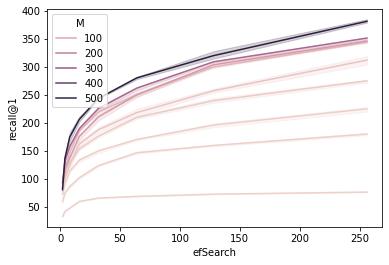

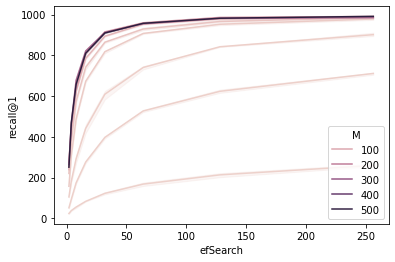

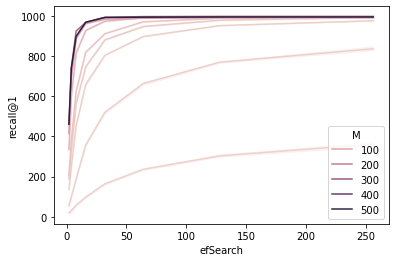

In [50]:
for efConstruction in [2, 16, 64]:
    sns.lineplot(data=results[results['efConstruction'] == efConstruction], x='efSearch', y='recall@1', hue='M')
    plt.show()

/var/folders/s0/_jtvm_x17pz3grlnzl2j8k6r0000gn/T/ipykernel_23753/88108748.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 500_000)


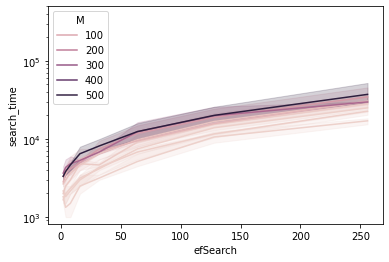

/var/folders/s0/_jtvm_x17pz3grlnzl2j8k6r0000gn/T/ipykernel_23753/88108748.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 500_000)


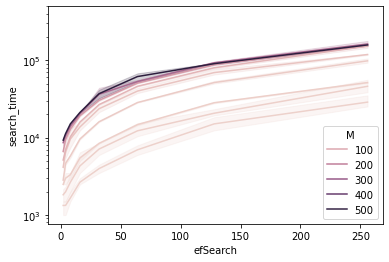

/var/folders/s0/_jtvm_x17pz3grlnzl2j8k6r0000gn/T/ipykernel_23753/88108748.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 500_000)


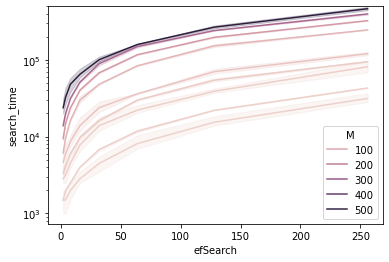

In [53]:
for efConstruction in [2, 16, 64]:
    sns.lineplot(data=results[results['efConstruction'] == efConstruction], x='efSearch', y='search_time', hue='M')
    plt.yscale('log')
    plt.ylim(0, 500_000)
    plt.show()

<AxesSubplot:xlabel='M', ylabel='memory_usage'>

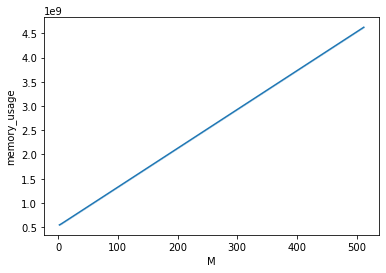

In [57]:
sns.lineplot(data=results, x='M', y='memory_usage')